In [1]:
import numpy
import math
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

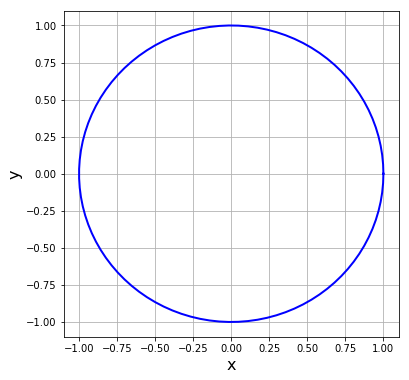

In [2]:
u_inf=1.0

# define the geometry
R=1.0
x_center, y_center = 0.0, 0.0
theta = numpy.linspace(0.0, 2*math.pi, num=100)
x_cylinder, y_cylinder = x_center + R*numpy.cos(theta),\
y_center + R*numpy.sin(theta)

# plot the cylinder
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [3]:
# create the panels on the cylinder
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 #center point
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2) #length of panel
        
        # angle of the panel: beta
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0 # tangential velocity
        self.cp = 0.0 # pressure coefficient

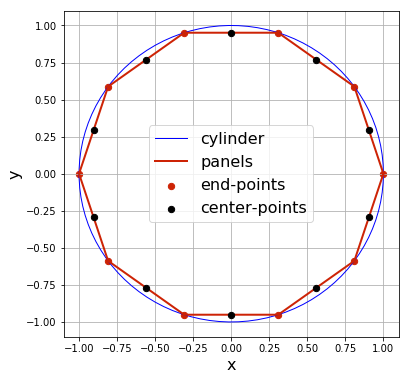

In [4]:
# now we want to store the panels in a numpy array

N_panels = 10 # number of panels

# define the end points
x_ends = R*numpy.cos(numpy.linspace(0.0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0.0, 2*math.pi, N_panels+1))

# we do N_panels+1 because we need 10 panels (or 10 in-between
# spaces) so we do N+1 to get 11 points with 10 in-between spaces

# define the panels
panels = numpy.empty(N_panels, dtype=object)

for i in range (N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plot it
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [5]:
# now we want to solve the normal velocity = 0 for each panel

def integral_normal(p_i, p_j):
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [6]:
# now we want to compute the strengths of the i panels using matrices
# here A will be everything multiplied by the strength sigma - the integral (when i doesn't = j) and 1/2 (when i = j)
# b will be -U_inf*cos(beta) as this is not multiplied by the strength
# X will be the strength sigma, which we solve for

A = numpy.empty((N_panels, N_panels), dtype = float)
numpy.fill_diagonal(A,0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i !=j:
            A[i,j]=0.5/math.pi*integral_normal(p_i,p_j)

# compuet the RHS of the linear system
b = -u_inf*numpy.cos([p.beta for p in panels])

# solve the linear system
sigma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [7]:
# compute the tangential velocity to get the pressure coefficient

def integral_tangential(p_i,p_j):
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]
    
# get the pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

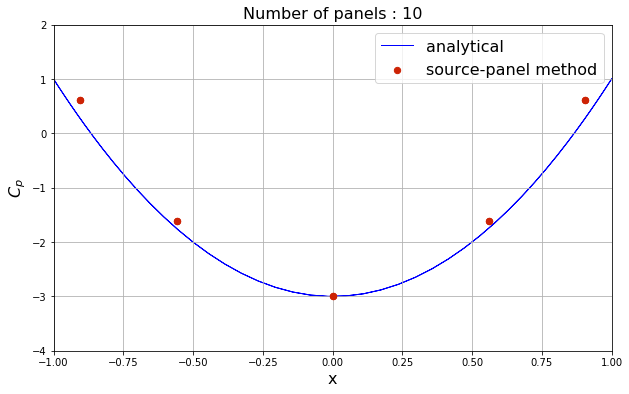

In [8]:
# find the analytical pressure coefficient on a cylinder for reference
cp_analytical = 1.0 - 4*(y_cylinder / R)**2

# plot it
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,label='analytical',color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],label='source-panel method',color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

We want to make the stream plotusing a meshgrid and the velocity components

In [19]:
# create the meshgrid
N_panels = 22 # number of panels
N=40
x_start, x_end = -1.5, 1.5
y_start, y_end = -1.5, 1.5
x=numpy.linspace(x_start, x_end, num=100)
y=numpy.linspace(y_start, y_end, num=100)
X,Y=numpy.meshgrid(x,y)

# derive the cartesian velocity components
def integral_vel(x, y, panel, dx, dy):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dx +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dy) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

# create the freestream for super position
AOA=0.0 # angle of the freestream
u_f=u_inf*numpy.cos(AOA)*numpy.ones_like(X)
v_f=u_inf*numpy.sin(AOA)*numpy.ones_like(Y)

# create the superposition
u=u_f.copy()
v=v_f.copy()
vec_integral=numpy.vectorize(integral_vel)
for panel in panels:
    u=u+panel.sigma/(2.0*math.pi)*vec_integral(X,Y,panel,1.0,0.0)
    v=v+panel.sigma/(2.0*math.pi)*vec_integral(X,Y,panel,0.0,1.0)

(-1.5, 1.5)

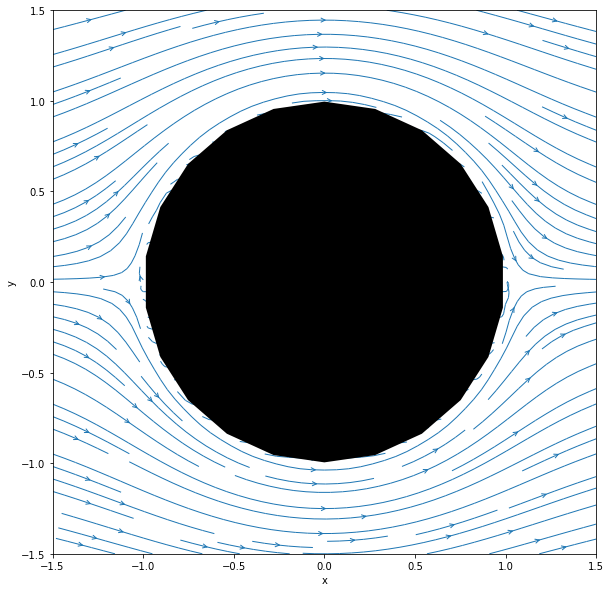

In [20]:
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=10)
pyplot.ylabel('y', fontsize=10)
pyplot.streamplot(X, Y, u, v, density=1.5, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],[panel.yc for panel in panels],color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

Now we want to increase the resolution by increasing the number of panels

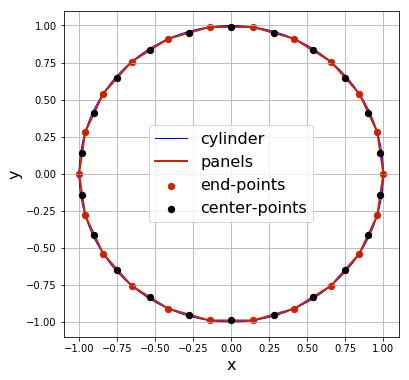

In [11]:
# now we want to store the panels in a numpy array

N_panels = 22 # number of panels

# define the end points
x_ends = R*numpy.cos(numpy.linspace(0.0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0.0, 2*math.pi, N_panels+1))

# we do N_panels+1 because we need 10 panels (or 10 in-between
# spaces) so we do N+1 to get 11 points with 10 in-between spaces

# define the panels
panels = numpy.empty(N_panels, dtype=object)

for i in range (N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# now we want to compute the strengths of the i panels using matrices
# here A will be everything multiplied by the strength sigma - the integral (when i doesn't = j) and 1/2 (when i = j)
# b will be -U_inf*cos(beta) as this is not multiplied by the strength
# X will be the strength sigma, which we solve for

A = numpy.empty((N_panels, N_panels), dtype = float)
numpy.fill_diagonal(A,0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i !=j:
            A[i,j]=0.5/math.pi*integral_normal(p_i,p_j)

# compuet the RHS of the linear system
b = -u_inf*numpy.cos([p.beta for p in panels])

# solve the linear system
sigma = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]
    
# plot it
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

(-2.0, 2.0)

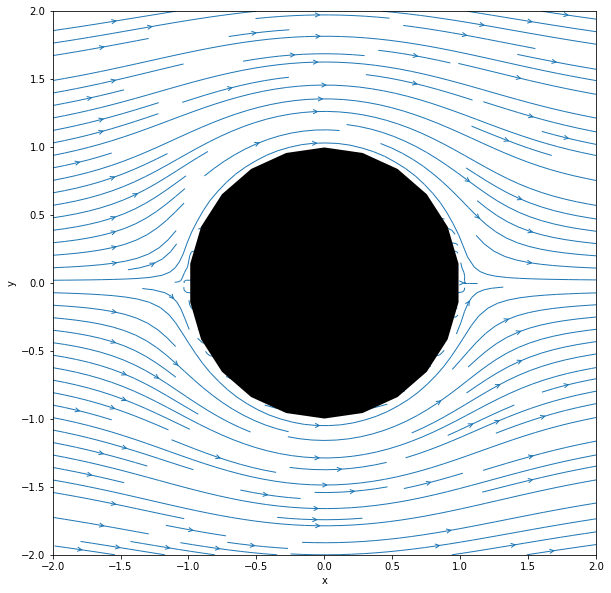

In [12]:
# create the meshgrid

N=50
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0
x=numpy.linspace(x_start, x_end, num=100)
y=numpy.linspace(y_start, y_end, num=100)
X,Y=numpy.meshgrid(x,y)

# derive the cartesian velocity components
def integral_vel(x, y, panel, dx, dy):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dx +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dy) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

# create the freestream for super position
AOA=0.0 # angle of the freestream
u_f=u_inf*numpy.cos(AOA)*numpy.ones_like(X)
v_f=u_inf*numpy.sin(AOA)*numpy.ones_like(Y)

# create the superposition
u=u_f.copy()
v=v_f.copy()
vec_integral=numpy.vectorize(integral_vel)
for panel in panels:
    u=u+panel.sigma/(2.0*math.pi)*vec_integral(X,Y,panel,1.0,0.0)
    v=v+panel.sigma/(2.0*math.pi)*vec_integral(X,Y,panel,0.0,1.0)
    
# plot the velocity field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=10)
pyplot.ylabel('y', fontsize=10)
pyplot.streamplot(X, Y, u, v, density=1.5, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],[panel.yc for panel in panels],color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)